# Gradient Boosting

   age  sex   BP  cholestrol  heart disease
0   70    1  130         322              1
1   67    0  115         564              0
2   57    1  124         261              1
3   64    1  128         263              0
4   74    0  120         269              0


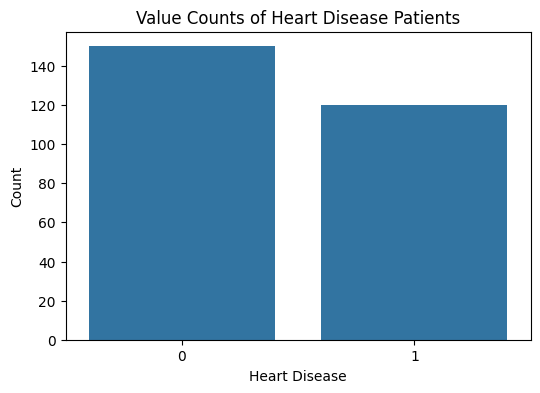

Train shape: (189, 4) Test shape: (81, 4)
CV Accuracy: 0.612 (0.086)
CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 5.01 μs
Confusion Matrix:
 [[26 19]
 [17 19]]
Test Accuracy: 0.5555555555555556
Fitting 4 folds for each of 72 candidates, totalling 288 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best CV Accuracy: 0.7086657801418439
Test Accuracy (Best Model): 0.5308641975308642


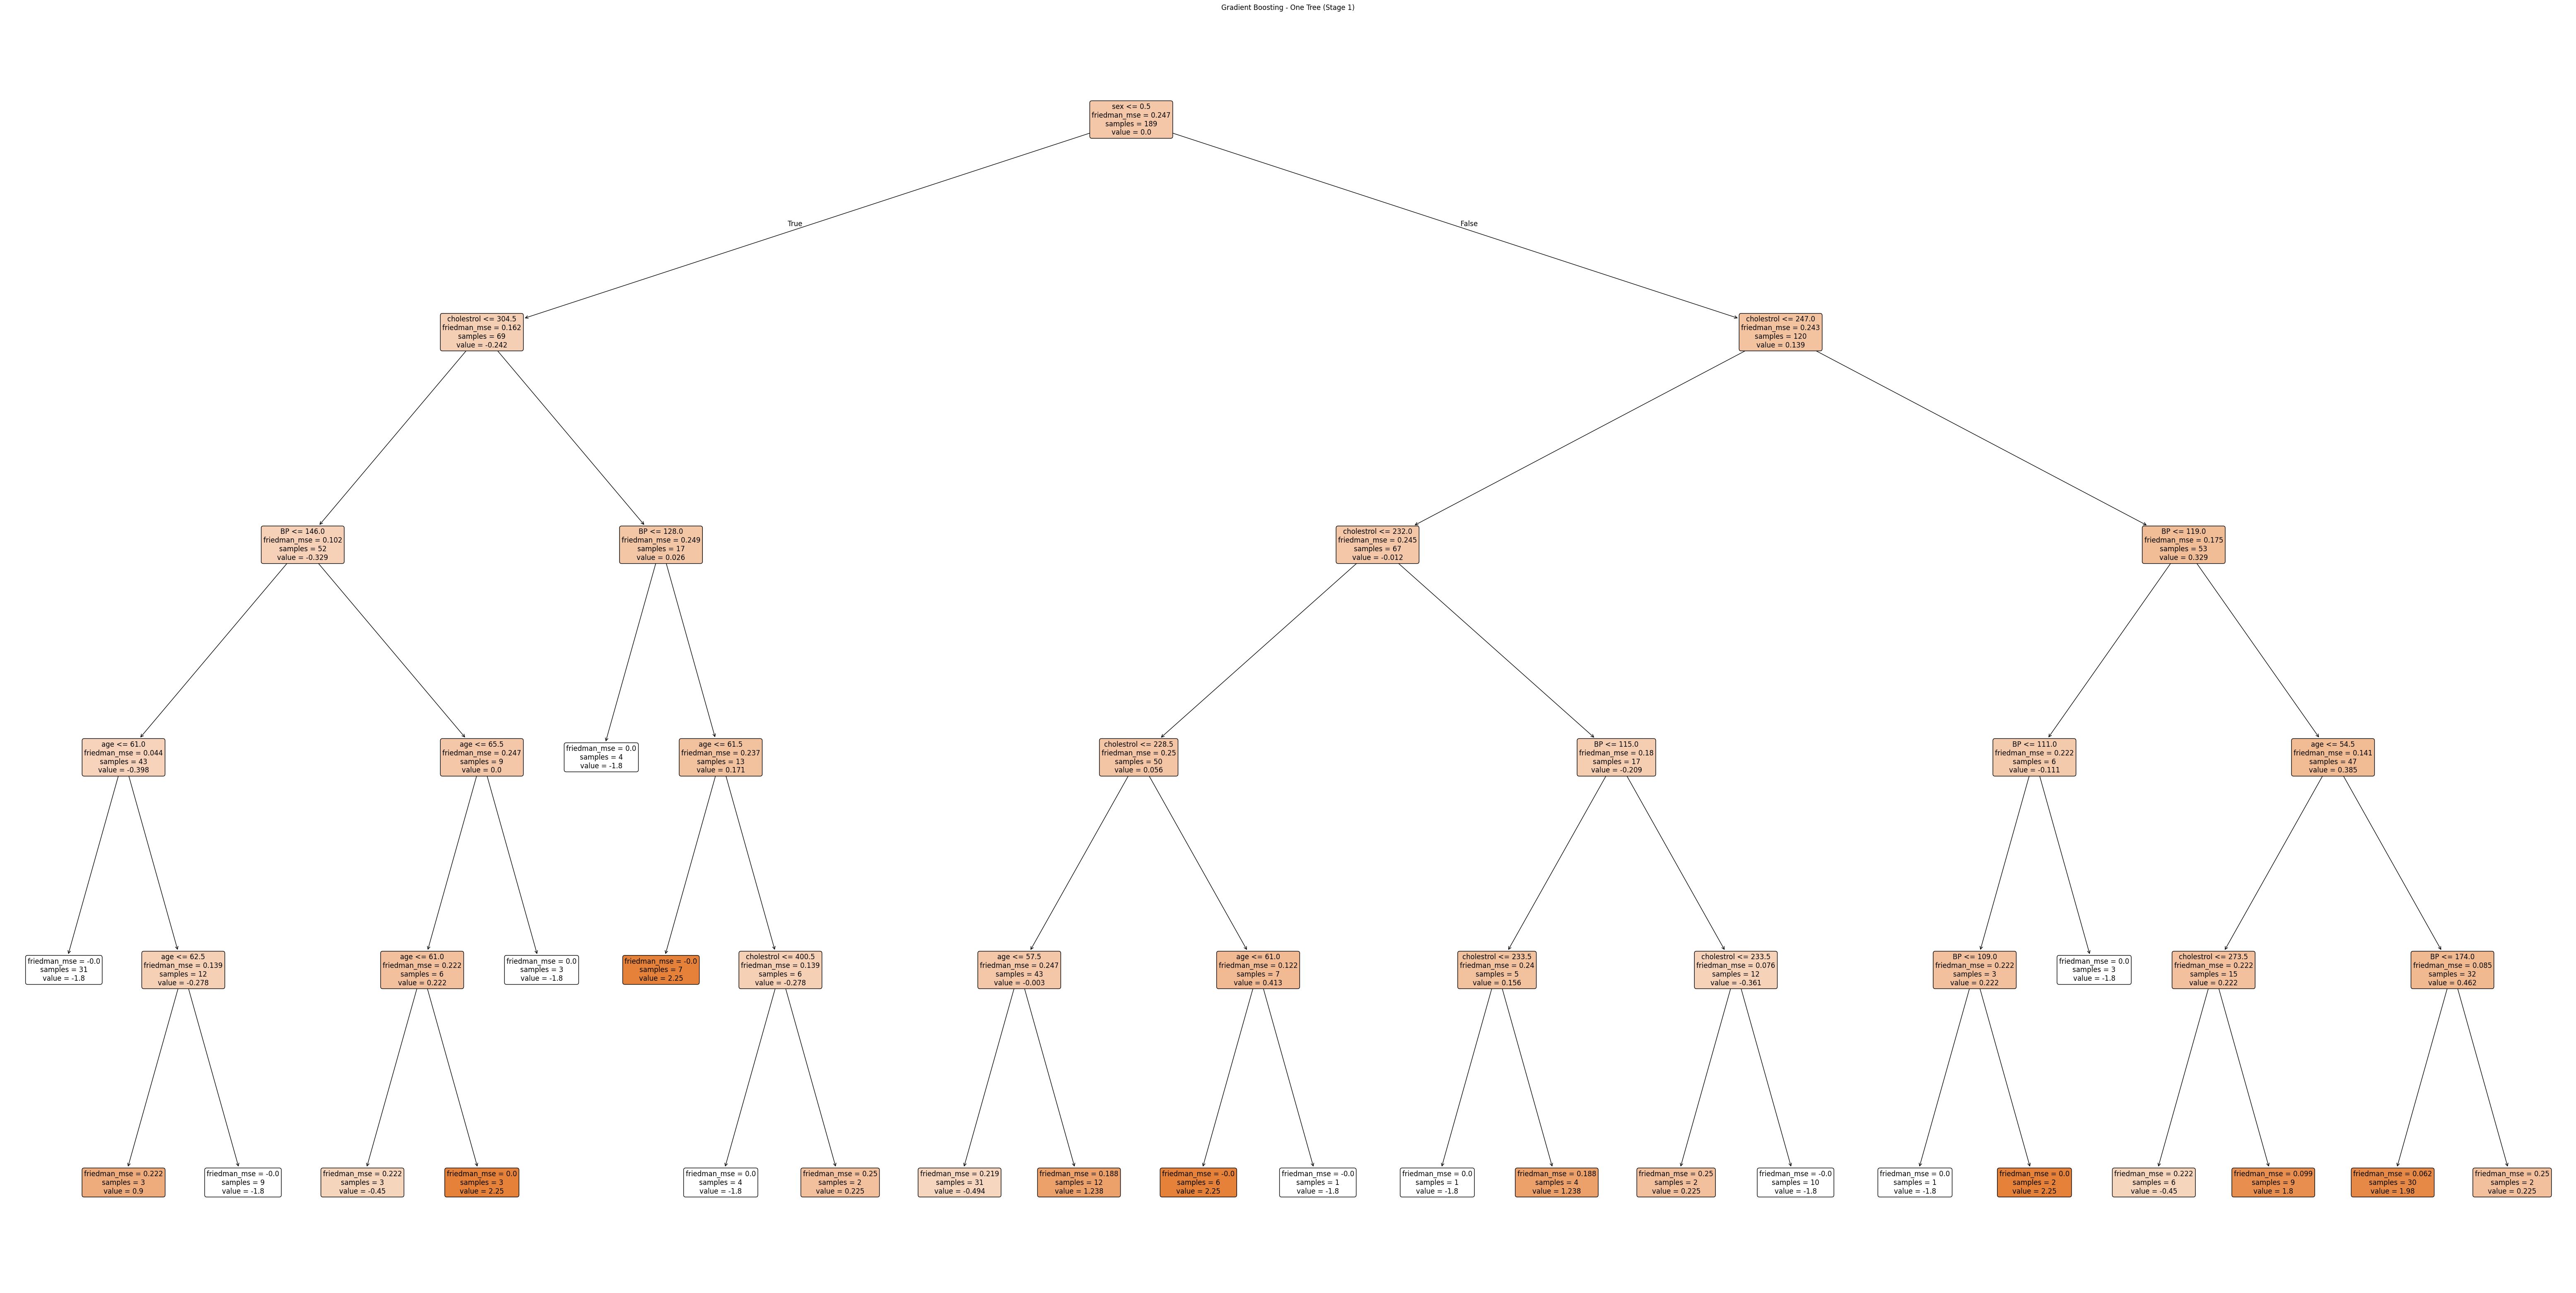

,Varname,Imp
3,cholestrol,0.347316
0,age,0.291505
2,BP,0.217300
1,sex,0.143879


In [1]:
# GradientBoostingClassifier - Full workflow (similar to your Random Forest steps)

# 1) Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 2) Load dataset + quick target distribution plot
df = pd.read_csv("heart_v2.csv")
print(df.head())

plt.figure(figsize=(6, 4))
sns.countplot(x="heart disease", data=df)
plt.title("Value Counts of Heart Disease Patients")
plt.xlabel("Heart Disease")
plt.ylabel("Count")
plt.show()

# 3) Put feature variables into X and target variable into y
X = df.drop("heart disease", axis=1)
y = df["heart disease"]

# 4) Train-Test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# 5) Train GradientBoostingClassifier + evaluate (CV + Test accuracy)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

gb_clf = GradientBoostingClassifier(random_state=42)

# Cross-validation (accuracy)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv_scores = cross_val_score(gb_clf, X, y, scoring="accuracy", cv=cv, n_jobs=-1)

print("CV Accuracy: %.3f (%.3f)" % (np.mean(cv_scores), np.std(cv_scores)))

# Fit on training data
%time
gb_clf.fit(X_train, y_train)

# Predict + evaluate on test set
y_pred = gb_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("Test Accuracy:", acc)

# 6) Hyperparameter tuning using GridSearchCV (similar to your RF grid step)
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [2, 3, 5],
    "subsample": [0.8, 1.0]
}

gb_base = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=gb_base,
    param_grid=param_grid,
    cv=4,
    n_jobs=-1,
    verbose=1,
    scoring="accuracy"
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

gb_best = grid_search.best_estimator_
test_acc_best = gb_best.score(X_test, y_test)
print("Test Accuracy (Best Model):", test_acc_best)

# 7) "Tree visualization" (similar idea)
# GradientBoostingClassifier stores individual trees in: estimators_[stage, class]
# For binary classification, class index is 0.
from sklearn.tree import plot_tree

plt.figure(figsize=(80, 40))
plot_tree(
    gb_best.estimators_[0, 0],        # first boosting stage, class 0
    feature_names=X.columns,
    class_names=["No Disease", "Disease"],
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title("Gradient Boosting - One Tree (Stage 1)")
plt.show()

# 8) Sort features using feature importance
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": gb_best.feature_importances_
}).sort_values(by="Imp", ascending=False)

imp_df
